In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import flax
import flax.linen as nn
import optax

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

from functools import partial

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import h5py
import healpy as hp 

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu


## Step I: Defining the model

In [5]:
print("######## CONFIG ########")

sigma_e = 0.26
galaxy_density = gal_per_arcmin2 = 10 / 4
field_size = map_size = size = 10
field_npix = N = xsize = 80
nside = 512
reso = size * 60 / xsize
nbins = 1
dim = 6
nside = 512
mean_pixel_area = 4 * np.pi / hp.nside2npix(nside)
scaling_factor = 1 / mean_pixel_area

# Create our fiducial observations
pix_area = (map_size * 60 / N)**2 # arcmin2
map_size_rad = map_size / 180 * jnp.pi # radians


print("######## OBSERVED DATA ########")
filename = '/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5'
f = h5py.File(filename, "r")
dataset_grid = f['parameters']['fiducial']
cosmo_parameters = jnp.array([
            dataset_grid['Om'],
            dataset_grid['s8'],
            dataset_grid['w0'],
            dataset_grid['H0']/100,
            dataset_grid['ns'],
            dataset_grid['Ob']
        ]).T
truth = list(cosmo_parameters[0])

path = '/gpfsdswork/dataset/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_baryonified512.h5'
m_data = h5py.File(path, "r")
m_data = np.array(m_data['kg']['stage3_lensing{}'.format(4)]) + np.array(m_data['ia']['stage3_lensing{}'.format(4)])


path = '/gpfsdswork/dataset/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_nobaryons512.h5'
m_data_nobaryon = h5py.File(path, "r")
m_data_nobaryon = np.array(m_data_nobaryon['kg']['stage3_lensing{}'.format(4)])
lmax = 3*nside - 1  
power_spectrum_nbody_map = hp.sphtfunc.anafast(m_data_nobaryon, lmax = lmax)
z = np.random.randn(hp.nside2npix(nside)) * np.sqrt(scaling_factor) 
power_spectrum_noise =  hp.sphtfunc.anafast(z, lmax = lmax)
power_spectrum_target = power_spectrum_nbody_map / power_spectrum_noise
alm_hp = hp.map2alm(z, lmax = lmax)
alm = hp.sphtfunc.almxfl(alm_hp, np.sqrt(power_spectrum_target))
gaussian_map = hp.alm2map(alm, nside, lmax = lmax)

proj = hp.projector.GnomonicProj(rot=[0, 0, 0], xsize=xsize, ysize=xsize, reso=reso)
m_data_proj = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))
gaussian_proj = proj.projmap(gaussian_map, vec2pix_func=partial(hp.vec2pix, nside))

m_data_proj_noisy = dist.Independent(
            dist.Normal(
                m_data_proj, 
                sigma_e / jnp.sqrt((galaxy_density * (field_size * 60 / field_npix) ** 2))
            ),
            2
        ).sample(jax.random.PRNGKey(0),(1,))

gaussian_proj_noisy = dist.Independent(
            dist.Normal(
                gaussian_proj, 
                sigma_e / jnp.sqrt((galaxy_density * (field_size * 60 / field_npix) ** 2))
            ),
            2
        ).sample(jax.random.PRNGKey(0),(1,))

######## CONFIG ########
######## OBSERVED DATA ########


## Step II: Defining utils functions

In [6]:
from jax_cosmo.redshift import redshift_distribution

class smail_nz(redshift_distribution):
    """Defines a smail distribution with these arguments
    Parameters:
    -----------
    a:

    b:

    z0:

    gals_per_arcmin2: number of galaxies per sq arcmin
    """

    def pz_fn(self, z):
        a, b, z0 = self.params
        return z**a * np.exp(-((z / z0) ** b))*4

In [7]:
filename = '/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5'
f = h5py.File(filename, "r")
dataset_grid = f['parameters']['fiducial']

cosmo_fid = jc.Planck15(
    Omega_c=dataset_grid['Om'][0] - dataset_grid['Ob'][0],
    Omega_b=dataset_grid['Ob'][0],
    h=dataset_grid['H0'][0] / 100,
    n_s=dataset_grid['ns'][0],
    sigma8=dataset_grid['s8'][0],
    Omega_k=0.0,
    w0=dataset_grid['w0'][0],
    wa=0.0,
)

def Pk_fn(k, cosmo, a_ai=None):
    pz = jc.redshift.smail_nz(3.53, 4.49, 1.03, gals_per_arcmin2=10/4)
    tracer = jc.probes.WeakLensing([pz], ia_bias=a_ai)
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    return jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)

def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=field_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0] ** 2 + kcoords[1] ** 2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    return ps_map * (N / field_size) ** 2

P = partial(Pk_fn, cosmo=cosmo_fid, a_ai=None)
    
# Creating a power spectrum map
power_map = make_power_map(P, N, map_size_rad)
# power_map =  make_lognormal_power_map(power_map, shift)
power_map = power_map.at[0,0].set(1.)

/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/linkhome/rech/genkqu01/uf

In [8]:
def log_gaussian_prior(map_data, ps_map=power_map, N=N):
    data_ft = jnp.fft.fft2(map_data).at[0,0].set(0.) / float(N)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map)) #+ jnp.log(jnp.sqrt(jnp.linalg.det(ps_map)))

## Step III: Data augmentation

In [9]:
import tensorflow as tf

def augmentation_noise(
    example, sigma_e=0.26, galaxy_density=27, field_size=5, field_npix=256
):
    x = example["map_nbody"]
    x += tf.random.normal(
        shape=(field_npix, field_npix),
        stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
    )

    return {"maps": x, "theta": example["theta"]}


def augmentation_flip(example):
    x = tf.expand_dims(example["maps"], -1)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return {"maps": x, "theta": example["theta"]}

def rescale_h(example): 
    x = example['theta']
    index_to_update = 3
    x = tf.tensor_scatter_nd_update(x, [[index_to_update]], [x[index_to_update] / 100])
    return {"maps": example["maps"], "theta": x}

def augmentation(example):
    return rescale_h(
        augmentation_flip(
            augmentation_noise(
                example=example,
                sigma_e=sigma_e,
                galaxy_density=galaxy_density,
                field_size=field_size,
                field_npix=field_npix,
            )
        )
    )


## Step III: Train the entire VAE

In [11]:
from unet_model import UResNet
from typing import Mapping, Optional, Sequence, Union
import haiku as hk

class UResNet18(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               use_bn: bool = None,
               pad_crop: bool = False,
               n_output_channels: int = 1,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      use_bn: Whether the network should use batch normalisation. Defaults to
        ``True``.
      n_output_channels: The number of output channels, for example to change in
        the case of a complex denoising. Defaults to 1.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(4, 8, 16),#(32, 64, 128, 128),#//2,
                     use_projection=(True, True, True),
                     # 320 -> 160 -> 80 -> 40
                     # 360 -> 180 -> 90 -> 45
                     strides=(2, 2, 1),
                     use_bn=use_bn,
                     pad_crop=pad_crop,
                     n_output_channels=n_output_channels,
                     name=name
                    )

In [12]:
# lets first try with fixed cosmo

@jax.jit
def posterior_z(y):
    return tfd.MultivariateNormalDiag(
        loc=y[...,0].flatten(),
        scale_diag=tfb.Softplus(low=1e-8).forward(y[...,1].flatten()+1e-2)
    )

@jax.jit
def posterior_x(y):
    return dist.Independent(
            dist.Normal(
                y, 
                sigma_e / jnp.sqrt((galaxy_density * (field_size * 60 / field_npix) ** 2))
            ),
            2
        )

@jax.jit
def log_posterior_x(y, x):
    return posterior_x(y).log_prob(x)

def compute_elbo(x, rng, M, state, params, weight): 
    
    state_encoder, state_decoder = state
    
    output_encoder, state_encoder = encoder.apply(
        params, 
        state_encoder,
        x.reshape([1,N,N,1])
    )
    
    p_z = posterior_z(output_encoder)
    z = p_z.sample(M, seed=rng)
    logp_z = p_z.log_prob(z)
    log_prior = jax.vmap(log_gaussian_prior)(z.reshape([M,N,N]))
    
    output_decoder, state_decoder = jax.vmap(lambda z : decoder.apply(params, state_decoder, z.reshape([1,N,N,1])))(z.reshape([M,N,N]))
#     output_decoder, state_decoder = jax.vmap(lambda z : decoder.apply(params, state_decoder, z.reshape([1,N,N,1])))(z.reshape([M,N,N])[0].reshape([1,N,N]))
    logp_x = jax.vmap(lambda y : log_posterior_x(y, x))(output_decoder.squeeze())
    
    return jnp.mean(logp_x - weight * (logp_z - log_prior)), ((state_encoder, state_decoder),(jnp.mean(-logp_x), jnp.mean(logp_z - log_prior)))
    

def loss_elbo(params, state, x, rng, weight):
    M = 20
    rng = jax.random.split(rng, len(x))
    elbo, state = jax.vmap(lambda x, rng : compute_elbo(x, rng, M, state, params, weight))(x,rng)

    return jnp.mean(-elbo), state

In [13]:
from functools import partial 
# @partial(jax.jit, static_argnums=4)
@jax.jit
def update(model_params, opt_state, state, x, rng, weight):
    (loss, state), grads = jax.value_and_grad(loss_elbo, has_aux=True)(
      model_params, state, x, rng, weight
    )
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(model_params, updates)
    return loss, new_params, new_opt_state, state[0], state[1]

In [14]:
# define decoder and encoder 

encoder = hk.without_apply_rng(hk.transform_with_state(
    lambda x : UResNet18(n_output_channels=2, name='encoder')(x.reshape([-1,N,N,1]), condition=None, is_training=True)
))
encoder_eval = hk.without_apply_rng(hk.transform_with_state(
    lambda x : UResNet18(n_output_channels=2, name='encoder')(x.reshape([-1,N,N,1]), condition=None, is_training=False)
))
params_encoder, state_encoder = encoder.init(
    jax.random.PRNGKey(0), 
    jnp.ones([1,N,N,1])
)


decoder = hk.without_apply_rng(hk.transform_with_state(
    lambda z : UResNet18(n_output_channels=1, name='decoder')(z.reshape([-1,N,N,1]), condition=None, is_training=True)
))
decoder_eval = hk.without_apply_rng(hk.transform_with_state(
    lambda z : UResNet18(n_output_channels=1, name='decoder')(z.reshape([-1,N,N,1]), condition=None, is_training=False)
))
params_decoder, state_decoder = decoder.init(
    jax.random.PRNGKey(0), 
    jnp.ones([1,N,N,1])
)

vae_params = hk.data_structures.merge(params_encoder, params_decoder)

In [15]:
total_steps = 5_000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=1e-3,
    boundaries_and_scales={
        int(total_steps * 0.1): 0.6,
#         int(total_steps * 0.2): 0.5,
        int(total_steps * 0.3): 0.5,
        int(total_steps * 0.5): 0.4,
        int(total_steps * 0.7): 0.3,
        int(total_steps * 0.9): 0.1,
    },
)

In [ ]:
from tqdm import tqdm
import tensorflow_datasets as tfds

ds_tr = tfds.load("CosmogridGridFiducialDataset/fiducial", split="train")

ds_tr = ds_tr.repeat()
ds_tr = ds_tr.shuffle(800)
ds_tr = ds_tr.map(augmentation)
ds_tr = ds_tr.batch(128)
ds_tr = ds_tr.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds_tr))

optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state = optimizer.init(vae_params)

state = (state_encoder, state_decoder)

store_loss = []
store_logp_z = []
store_logp_x = []
master_seed = jax.random.PRNGKey(0)

nb_epoch = 100
weight_schedule = jnp.linspace(0.5, 1, nb_epoch)

for batch in tqdm(range(total_steps)):

    master_seed, rng = jax.random.split(master_seed, 2)
    ex = next(ds_train)
    x = ex['maps'].squeeze()
    b_loss, vae_params, opt_state, state, logp = update(
        vae_params,
        opt_state,
        state,
        x,
        rng,
        1 #weight_schedule[epoch]
    )
    store_loss.append(b_loss)
    store_logp_z.append(logp[1])
    store_logp_x.append(logp[0])

In [124]:
for batch in tqdm(range(total_steps//2)):

    master_seed, rng = jax.random.split(master_seed,2)
    ex = next(ds_train)
    x = ex['maps'].squeeze()
    b_loss, vae_params, opt_state, state, logp = update(
        vae_params,
        opt_state,
        state,
        x,
        rng,
        1 #weight_schedule[epoch]
    )
    store_loss.append(b_loss)
    store_logp_z.append(logp[1])
    store_logp_x.append(logp[0])

100%|██████████| 2500/2500 [22:11<00:00,  1.88it/s]


In [ ]:
# save params
with open(f"./save_params/params_nd_vae_batch{batch}.pkl", "wb") as fp:
    pickle.dump(vae_params, fp)

with open(f"./save_params/opt_state_vae_batch{batch}.pkl", "wb") as fp:
    pickle.dump(opt_state, fp)

 with open(f"./save_params/state_vae_batch{batch}.pkl", "wb") as fp:
    pickle.dump(state, fp)

In [140]:
for batch in tqdm(range(total_steps//2)):

    master_seed, rng = jax.random.split(master_seed,2)
    ex = next(ds_train)
    x = ex['maps'].squeeze()
    b_loss, vae_params, opt_state, state, logp = update(
        vae_params,
        opt_state,
        state,
        x,
        rng,
        1 #weight_schedule[epoch]
    )
    store_loss.append(b_loss)
    store_logp_z.append(logp[1])
    store_logp_x.append(logp[0])

100%|██████████| 2500/2500 [22:10<00:00,  1.88it/s]


In [157]:
for batch in tqdm(range(total_steps)):

    master_seed, rng = jax.random.split(master_seed,2)
    ex = next(ds_train)
    x = ex['maps'].squeeze()
    b_loss, vae_params, opt_state, state, logp = update(
        vae_params,
        opt_state,
        state,
        x,
        rng,
        1 #weight_schedule[epoch]
    )
    store_loss.append(b_loss)
    store_logp_z.append(logp[1])
    store_logp_x.append(logp[0])

100%|██████████| 5000/5000 [44:21<00:00,  1.88it/s]


In [173]:
for batch in tqdm(range(total_steps)):

    master_seed, rng = jax.random.split(master_seed,2)
    ex = next(ds_train)
    x = ex['maps'].squeeze()
    b_loss, vae_params, opt_state, state, logp = update(
        vae_params,
        opt_state,
        state,
        x,
        rng,
        1 #weight_schedule[epoch]
    )
    store_loss.append(b_loss)
    store_logp_z.append(logp[1])
    store_logp_x.append(logp[0])

100%|██████████| 5000/5000 [44:20<00:00,  1.88it/s]


In [194]:
for batch in tqdm(range(total_steps*3)):

    master_seed, rng = jax.random.split(master_seed,2)
    ex = next(ds_train)
    x = ex['maps'].squeeze()
    b_loss, vae_params, opt_state, state, logp = update(
        vae_params,
        opt_state,
        state,
        x,
        rng,
        1 #weight_schedule[epoch]
    )
    store_loss.append(b_loss)
    store_logp_z.append(logp[1])
    store_logp_x.append(logp[0])

100%|██████████| 15000/15000 [2:13:09<00:00,  1.88it/s] 


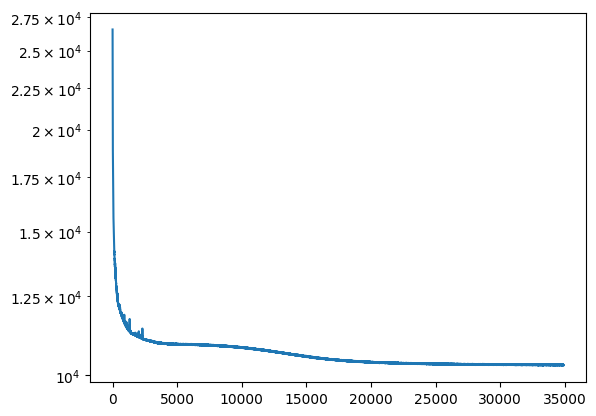

In [196]:
plt.semilogy(store_loss[100:])

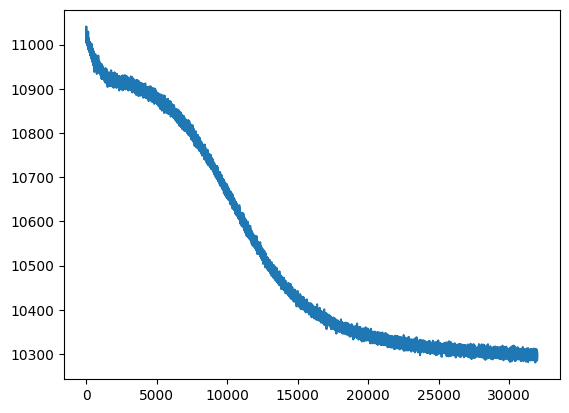

In [197]:
plt.plot(store_loss[3000:])

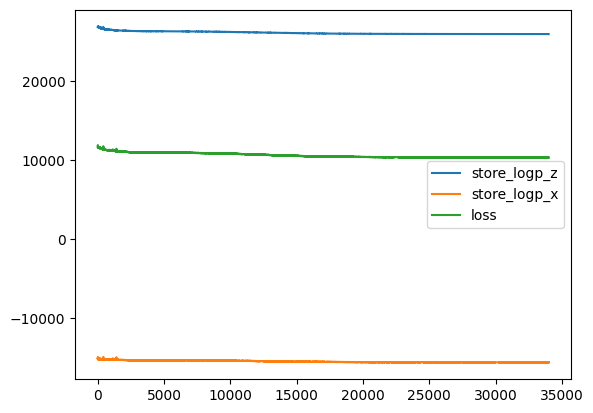

In [198]:
i = 1000
plt.plot(jnp.mean(jnp.array(store_logp_z)[i:],axis=1), label = 'store_logp_z')
plt.plot(jnp.mean(jnp.array(store_logp_x)[i:],axis=1), label = 'store_logp_x')
plt.plot(store_loss[i:], label ='loss')
plt.legend()

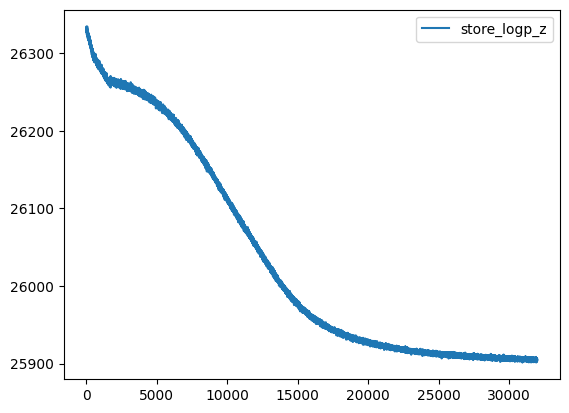

In [199]:
i = 3000
plt.plot(jnp.mean(jnp.array(store_logp_z)[i:],axis=1), label = 'store_logp_z')
plt.legend()

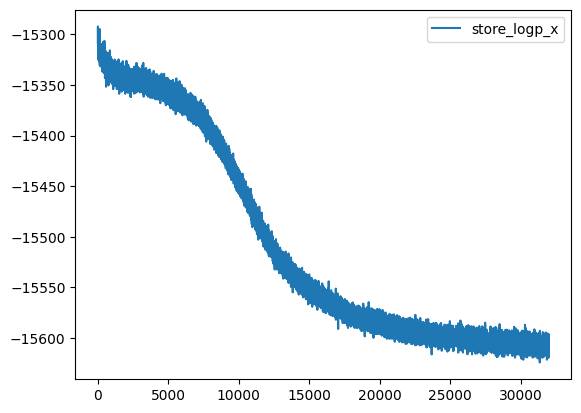

In [200]:
i = 3000
plt.plot(jnp.mean(jnp.array(store_logp_x)[i:],axis=1), label = 'store_logp_x')
plt.legend()

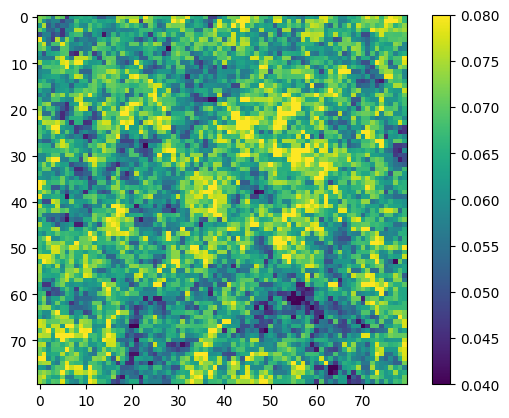

In [202]:
plt.imshow(gaussian_proj.squeeze()+0.12, vmax = 0.08, vmin = 0.04); colorbar()

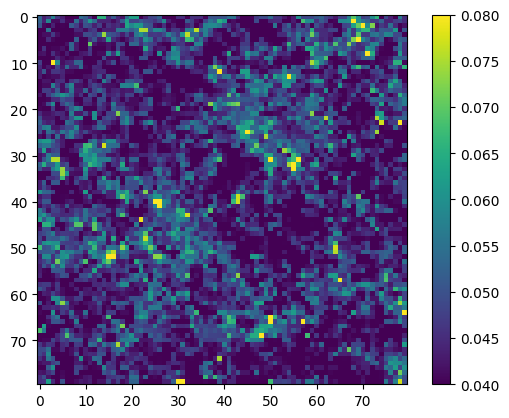

In [203]:
plt.imshow(m_data_proj.squeeze(), vmax=0.08,vmin = 0.04); colorbar();

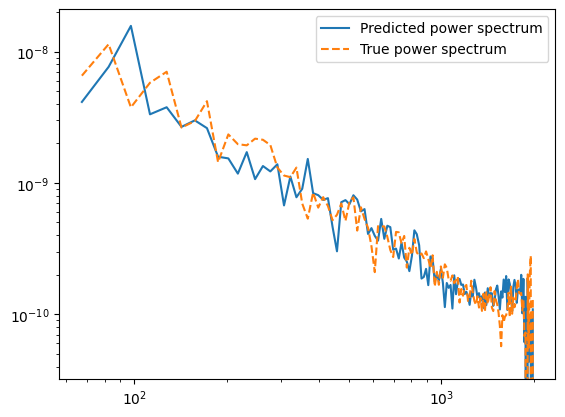

In [204]:
from lenstools import ConvergenceMap
import astropy.units as u
np.float = float 
np.complex = complex

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)#jnp.logspace(0, 3, 128) # np.arange(60.0, 2000.0, 15.0)

kmap_lt_predicted = ConvergenceMap(
    m_data_proj.squeeze(), angle=map_size * u.deg
)
l1,Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
   gaussian_proj.squeeze(), angle=map_size * u.deg
)
l2,Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.loglog(l1, Pl1, label ='Predicted power spectrum')
plt.loglog(l2, Pl2, '--', label ='True power spectrum')
plt.legend()

In [25]:
out_encoder,_ = encoder_eval.apply(vae_params, state[0], m_data_proj_noisy[0])
out_decoder,_ = decoder_eval.apply(vae_params, state[1], gaussian_proj.squeeze())

minimum std:  0.013233565


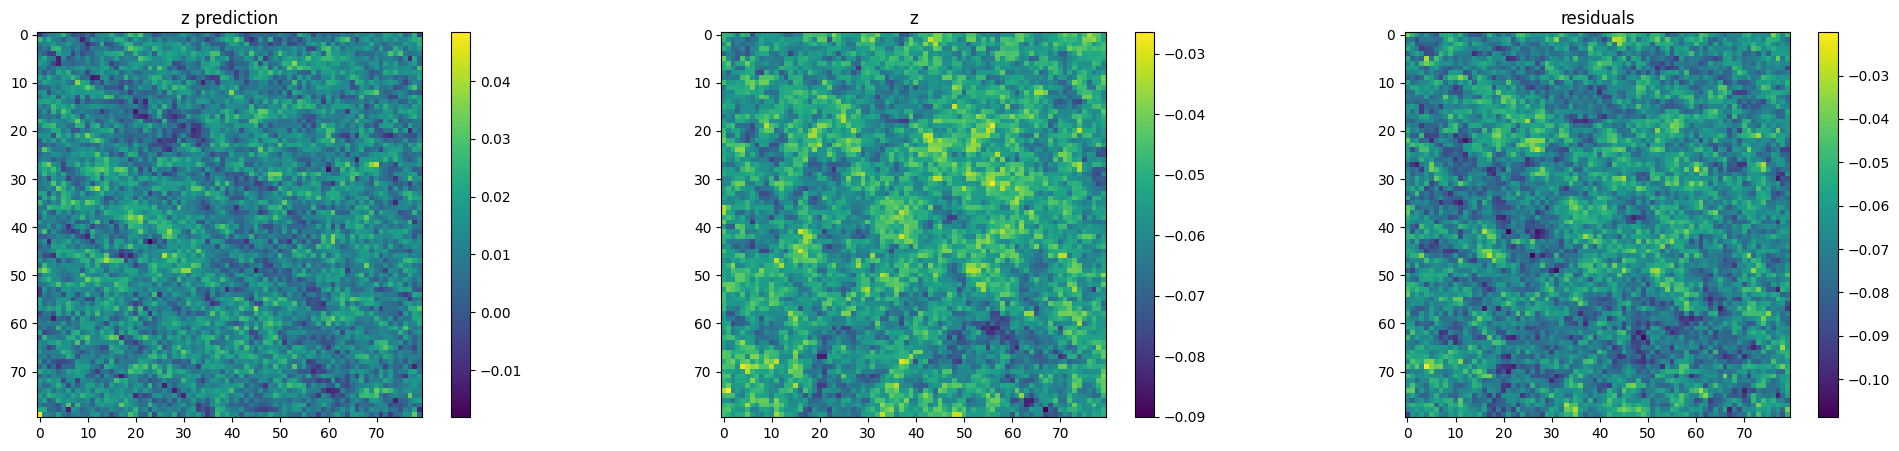

In [206]:
figure(figsize=(25,5))

sample_encoder = posterior_z(out_encoder).sample(seed=jax.random.PRNGKey(0))
sample_encoder = sample_encoder.reshape([N,N])
subplot(131)
imshow(sample_encoder.squeeze())
title('z prediction')
colorbar()

subplot(132)
imshow(gaussian_proj.squeeze())
title('z')
colorbar()

subplot(133)
imshow(gaussian_proj.squeeze()- sample_encoder.squeeze())
title('residuals')
colorbar()

print('minimum std: ', (tfb.Softplus(low=1e-8).forward(out_encoder[...,1].squeeze())+1e-2).min())

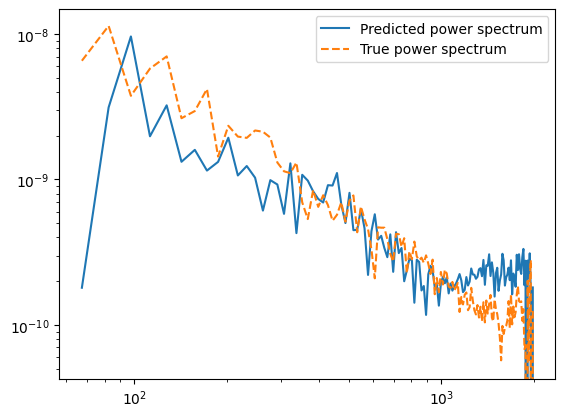

In [207]:
from lenstools import ConvergenceMap
import astropy.units as u
np.float = float 
np.complex = complex

l_edges_kmap = np.arange(60.0, 2000.0, 15.0) #jnp.logspace(0, 3, 128)

kmap_lt_predicted = ConvergenceMap(
    sample_encoder, angle=map_size * u.deg
)
l1,Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    gaussian_proj.squeeze(), angle=map_size * u.deg
)
l2,Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.loglog(l1, Pl1, label ='Predicted power spectrum')
plt.loglog(l2, Pl2, '--', label ='True power spectrum')
plt.legend()

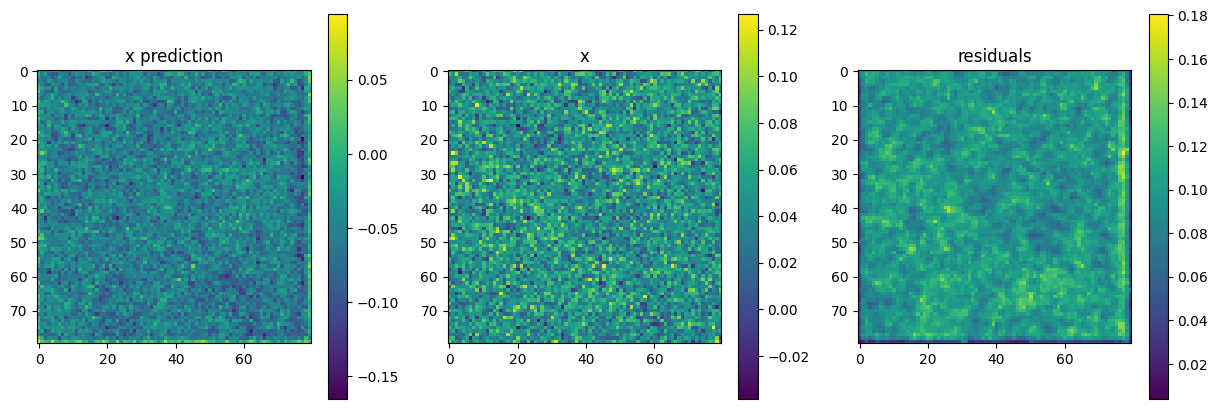

In [208]:
sample_decoder = posterior_x(out_decoder.squeeze()).sample(jax.random.PRNGKey(0))

figure(figsize=(15,5))
subplot(131)
imshow(sample_decoder)
title('x prediction')
colorbar()
subplot(132)
imshow(m_data_proj_noisy[0])
title('x')
colorbar()
subplot(133)
imshow(m_data_proj_noisy[0] - sample_decoder.squeeze())
title('residuals')
colorbar()

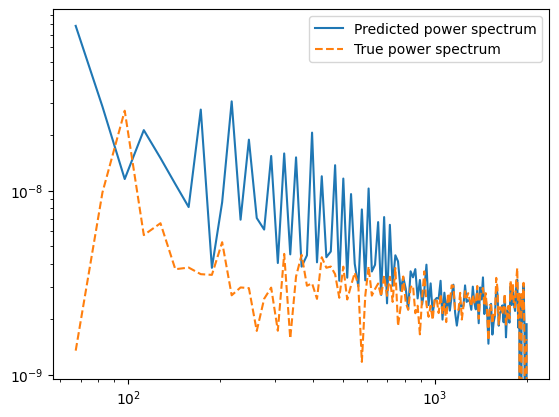

In [209]:
from lenstools import ConvergenceMap
import astropy.units as u
np.float = float 
np.complex = complex

l_edges_kmap = np.arange(60.0, 2000.0, 15.0) #jnp.logspace(0, 3, 128)

kmap_lt_predicted = ConvergenceMap(
    sample_decoder, angle=map_size * u.deg
)
l1,Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    m_data_proj_noisy[0], angle=map_size * u.deg
)
l2,Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.loglog(l1, Pl1, label ='Predicted power spectrum')
plt.loglog(l2, Pl2, '--', label ='True power spectrum')
plt.legend()

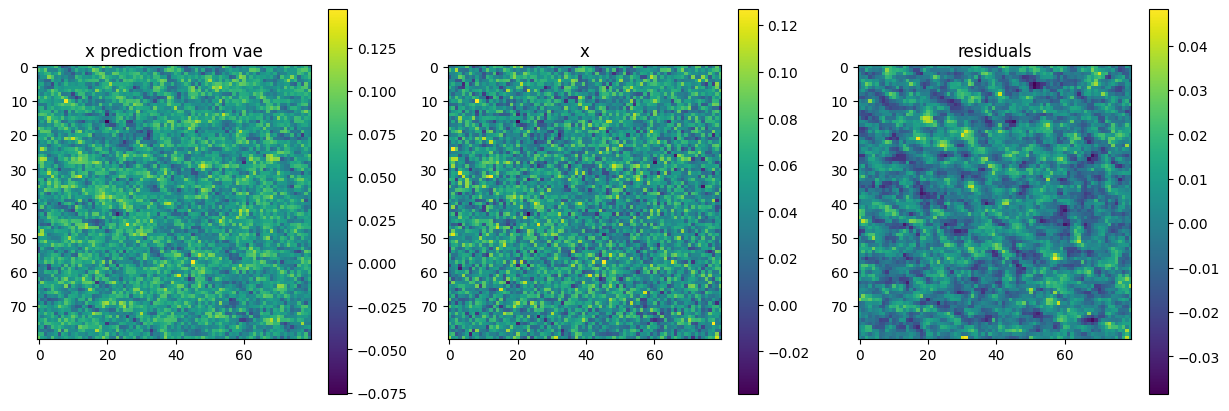

In [210]:
out_vae,_ = decoder_eval.apply(vae_params, state[1], sample_encoder)

sample_vae = posterior_x(out_vae.squeeze()).sample(jax.random.PRNGKey(0))

figure(figsize=(15,5))
subplot(131)
imshow(sample_vae)
title('x prediction from vae')
colorbar()
subplot(132)
imshow(m_data_proj_noisy[0])
title('x')
colorbar()
subplot(133)
imshow(m_data_proj_noisy[0] - sample_vae.squeeze())
title('residuals')
colorbar()

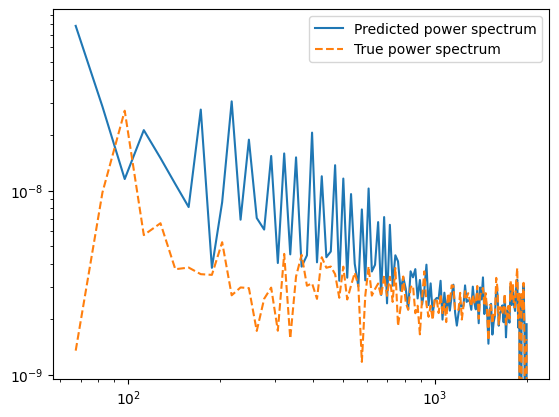

In [211]:
from lenstools import ConvergenceMap
import astropy.units as u
np.float = float 
np.complex = complex

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)#jnp.logspace(0, 3, 128)
# l_edges_kmap = jnp.logspace(0, 3, 128)
kmap_lt_predicted = ConvergenceMap(
    sample_decoder, angle=map_size * u.deg
)
l1,Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
    m_data_proj_noisy[0], angle=map_size * u.deg
)
l2,Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.loglog(l1, Pl1, label ='Predicted power spectrum')
plt.loglog(l2, Pl2, '--', label ='True power spectrum')
plt.legend()

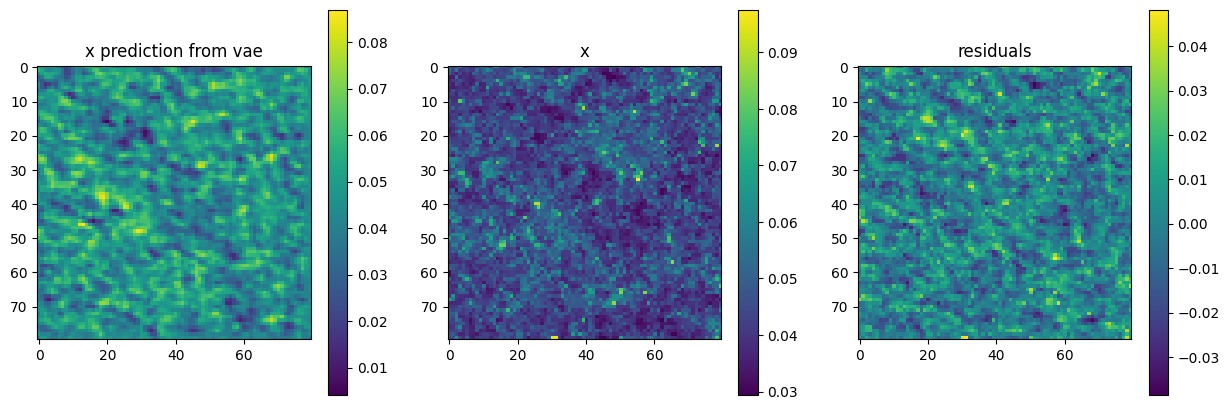

In [212]:
out_encoder,_ = encoder_eval.apply(vae_params, state[0], m_data_proj_noisy[0])
sample_decoder = posterior_x(out_decoder.squeeze()).sample(jax.random.PRNGKey(0))
out_vae,_ = decoder_eval.apply(vae_params, state[1], sample_encoder)

sample_vae = posterior_x(out_vae.squeeze()).sample(jax.random.PRNGKey(0))

figure(figsize=(15,5))
subplot(131)
imshow(out_vae.squeeze())
title('x prediction from vae')
colorbar()
subplot(132)
imshow(m_data_proj.squeeze())
title('x')
colorbar()
subplot(133)
imshow(m_data_proj.squeeze() - out_vae.squeeze())
title('residuals')
colorbar()

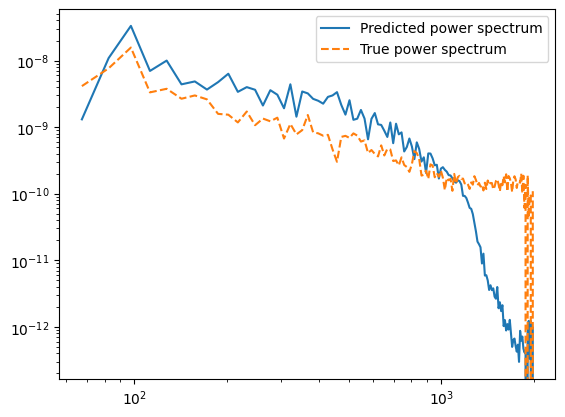

In [213]:
from lenstools import ConvergenceMap
import astropy.units as u
np.float = float 
np.complex = complex

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)#jnp.logspace(0, 3, 128)
# l_edges_kmap = jnp.logspace(0, 3, 128)
kmap_lt_predicted = ConvergenceMap(
out_vae.squeeze(), angle=map_size * u.deg
)
l1,Pl1 = kmap_lt_predicted.powerSpectrum(l_edges_kmap)

kmap_lt_true = ConvergenceMap(
m_data_proj.squeeze(), angle=map_size * u.deg
)
l2,Pl2 = kmap_lt_true.powerSpectrum(l_edges_kmap)

plt.loglog(l1, Pl1, label ='Predicted power spectrum')
plt.loglog(l2, Pl2, '--', label ='True power spectrum')
plt.legend()

In [ ]:
import pickle

with open(
    "params_vae.pkl", "wb"
) as fp:
    pickle.dump(vae_params, fp)

with open("opt_state_vae.pkl", "wb") as fp:
    pickle.dump(state, fp)
    
with open("opt_state.pkl", "wb") as fp:
    pickle.dump(opt_state, fp)